# Stance Detection Using Bidirectional Long Short-Term Memory Followed By Convolutional Neural Network

`Convolutional Neural Networks` `Bidirectional Long Short-Term Memory`  `Ensemble Model`  
`AraVec Word Vectors`  
`AraStance Dataset`  
`Stance Detection` `Arabic Language` `Transfer Learning`

---

In this notebook, we rely on an ensemble comprising a very simple bidirectional long short-term memory and a convolutional neural network to classify the stances of the articles in the AraStance dataset. The dataset was introduced in the paper:
```
AraStance: A Multi-Country and Multi-Domain Dataset of Arabic Stance Detection for Fact Checking.
```
The pretrained vectors (AraVec project) was introduced in the paper:
```
AraVec: A set of Arabic Word Embedding Models for use in Arabic NLP.
```

## Packages

In [ ]:
!pip install gensim
!pip install pyarabic

In [ ]:
import gensim
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from preprocessing import *
from utils import AraStanceData, evaluate, stance_to_int

## Raw data

- Download the raw data:



In [ ]:
!wget https://github.com/Tariq60/arastance/archive/refs/heads/main.zip
!unzip /content/main.zip

- Let's start by reading the raw data:

In [ ]:
raw_train = AraStanceData("/content/arastance-main/data/train.jsonl")
raw_val = AraStanceData("/content/arastance-main/data/dev.jsonl")
raw_test = AraStanceData("/content/arastance-main/data/test.jsonl")

print(f'# training instances: {len(raw_train.stances)}')
print(f'# validation instances: {len(raw_val.stances)}')
print(f'# testing instances: {len(raw_test.stances)}')

# training instances: 2848
# validation instances: 569
# testing instances: 646


- Let's see an instance from the data:

In [ ]:
instance_no = 100
print(f"Claim text: {raw_train.claims[raw_train.article_claim[instance_no]]}")
print(f"Article text: {raw_train.articles[instance_no]}")
print(f"Stance: {raw_train.stances[instance_no]}")

Claim text: حل سحري لحرق الدهون في الجسم
Article text: رجيم العسل و الليمون لخسارة الوزن و حرق الدهون بطريقة أمنة و صحية و في وقت سريع هو الحل المثالي للتمتع بالرشاقة و الجسم المشدود الذي تحلمين به. يتميز رجيم العسل و الليمون بمذاق خليط العسل و الليمون اللذيذ و بفوائده الكثيرة للتخلص من السمنة و الكيلوغرامات الزائدة، وقد أكدت الكثير من الدراسات حقيقة و فعالية رجيم العسل و الليمون لحرق الدهون و تنقية الجسم من السموم و زيادة كمية البول. و من فوائد رجيم العسل و الليمون علاوة على خسارة الوزن و حرق الدهون، أنه يسدّ حاجة الجسم الى السكريات و يعمل على كبح الرغبة لتناول الطعام، و إمداد الجسم بالطاقة اللازمة طوال اليوم. كيفية تناول رجيم العسل و الليمون إذابة ملعقة صغيرة من العسل في ماء ساخن مع عصير ليمونة كاملة و شربه كل صباح على معدة خاوية و قبل تناول أي طعام. واظبي على تناول هذا المشروب لمدة شهر على الأقل بصفة يومية، مع الإلتزام باتباع نظام غذائي صحي يمنع فيه تناول الأطعمة الدسمة و الدهون إلى جانب ممارسة بعض التمرينات الرياضية و شرب الماء بكثرة، الأمر الذي سيساعد أيضاً على خسارة الوزن و الحصو

- Thus, the instances are triplets, Claim/Article/Stance.
- Note that the original language of the data is Arabic.

## Embedding layer

- We will use AraVec pretrained word vectors to represent the input.

### Preprocessing

- To increase the hit rate between the words in our raw data and the tokens (i.e. the keys in AraVec dictionary) in AraVec dictionary, we need to preprocess the data in a way similar to the preprocessing performed to produce those tokens.

- Let's use the following function to preprocess the training, validation, and testing data:

In [ ]:
# this function is resposible for the preprocessing routine
def preprocess(instances):
  instances = list(map(remove_puncuation, instances))
  instances = list(map(remove_diacritics, instances))
  instances = list(map(remove_longation, instances))
  instances = list(map(remove_unicode_codes, instances))
  instances = list(map(process_numerals, instances))
  instances = list(map(normalize, instances))
  instances = list(map(remove_extra_spaces, instances))
  return instances

- Before preprocessing each claim article pair, we need to concatenate them.

In [ ]:
# preprocess training data
train_instances = [raw_train.claims[raw_train.article_claim[idx]] + " " + article \
                  for idx, article in enumerate(raw_train.articles)]
preprocessed_train_instances = preprocess(train_instances)

# preprocess validation data
val_instances = [raw_val.claims[raw_val.article_claim[idx]] + " " + article \
                  for idx, article in enumerate(raw_val.articles)]
preprocessed_val_instances = preprocess(val_instances)

# preprocess testing data
test_instances = [raw_test.claims[raw_test.article_claim[idx]] + " " + article \
                  for idx, article in enumerate(raw_test.articles)]
preprocessed_test_instances = preprocess(test_instances)

- Let's see a preprocessed instance:

In [ ]:
instance_no = 100
print(f"Claim Article text: {preprocessed_train_instances[instance_no]}")
print(f"Stance: {raw_train.stances[instance_no]}")

Claim Article text: حل سحري لحرق الدهون في الجسم رجيم العسل و الليمون لخساره الوزن و حرق الدهون بطريقه امنه و صحيه و في وقت سريع هو الحل المثالي للتمتع بالرشاقه و الجسم المشدود الذي تحلمين به يتميز رجيم العسل و الليمون بمذاق خليط العسل و الليمون اللذيذ و بفوائده الكثيره للتخلص من السمنه و الكيلوغرامات الزائده وقد اكدت الكثير من الدراسات حقيقه و فعاليه رجيم العسل و الليمون لحرق الدهون و تنقيه الجسم من السموم و زياده كميه البول و من فوائد رجيم العسل و الليمون علاوه علي خساره الوزن و حرق الدهون انه يسد حاجه الجسم الي السكريات و يعمل علي كبح الرغبه لتناول الطعام و امداد الجسم بالطاقه اللازمه طوال اليوم كيفيه تناول رجيم العسل و الليمون اذابه ملعقه صغيره من العسل في ماء ساخن مع عصير ليمونه كامله و شربه كل صباح علي معده خاويه و قبل تناول اي طعام واظبي علي تناول هذا المشروب لمده شهر علي الاقل بصفه يوميه مع الالتزام باتباع نظام غذائي صحي يمنع فيه تناول الاطعمه الدسمه و الدهون الي جانب ممارسه بعض التمرينات الرياضيه و شرب الماء بكثره الامر الذي سيساعد ايضا علي خساره الوزن و الحصول علي نتيجه مذهله

### Initialization

- Download the pretrained vectors first:

In [ ]:
!wget "https://bakrianoo.ewr1.vultrobjects.com/aravec/full_uni_cbow_300_wiki.zip"
!unzip "full_uni_cbow_300_wiki.zip"

- Load the pretrained vectors:

In [ ]:
embedding_model = gensim.models.Word2Vec.load("full_uni_cbow_300_wiki.mdl")
print("AraVect project contains",len(embedding_model.wv.index_to_key),"tokens")

AraVect project contains 320636 tokens


- We need to decide on the words we are going to use in the final representation of each instance, so we will use a vectorization layer to learn a vocabulary from our training data. We allowed 30K tokens in our vocabulary.
- We also going to need a word index, which maps words to indices like `{word1-->idx1, word2-->idx2, ...}`. The indices will be used to store the vector representation of each word in the embedding matrix.

In [ ]:
# Option 1 using TextVectorization layer
# max_tokens represents the maximum size of the vocabulary
vectorizer = tf.keras.layers.TextVectorization(max_tokens=30000, output_sequence_length=300, standardize=None)
text_ds = tf.data.Dataset.from_tensor_slices(preprocessed_train_instances).batch(128)

# learn the vocabulary based on the training data
vectorizer.adapt(text_ds)

voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

# Option 2 using NLTK tokenizer
# import nltk
# from nltk import  word_tokenize
# nltk.download('punkt')

# def tokenization(text):
#   return word_tokenize(text)

# train_tokenized = list(map(tokenization, train_samples))
# tokens = [token for sublist in train_tokenized for token in sublist]
# tokens = set(tokens)
# word_index = dict(zip(tokens, range(len(tokens))))
# len(tokens)

- We are now ready to create an embedding matrix which maps token indices of our vocabulary to pretrained word vectors from AraVec project:

In [ ]:
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
  if embedding_model.wv.__contains__(word):
    embedding_matrix[i] = embedding_model.wv.get_vector(word)
    hits += 1
  else:
    misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 29578 words (422 misses)


- Let's see the representation of a random token:

In [ ]:
print(f"The word 'الدهون' is at index {word_index['الدهون']}")
print(f"The vector representation of 'الدهون' is {embedding_matrix[word_index['الدهون']]}")

The word 'الدهون' is at index 3343
The vector representation of 'الدهون' is [-4.30883217  1.56213009  1.8602798  -0.62370169 -2.35083222  2.39131665
  3.77460217 -1.85717797 -0.66889107  2.38038826  0.89662308 -2.58325481
  3.73695707 -0.36463404  3.16101193 -1.1231699  -1.37733424  2.83819652
 -2.2359736  -1.09134352  0.16668355  1.25111842 -0.63004589  0.97106349
  0.78251129 -0.30544958 -1.88110328 -0.18281475 -2.12635398  0.90880096
 -0.36081177 -3.69800615 -1.2177031  -0.7795617   0.18667516  2.08246636
 -2.61052251  0.27115086 -0.49193525  3.81226754  1.93155444  3.08217645
  1.65794206  0.27892774  3.40922952 -2.44117665  1.50639844 -1.45165777
 -0.59680653 -0.73478156  3.83109546  1.76000941 -0.65592682 -0.90347373
 -0.10801595  1.25446546 -0.57598352 -2.49452424  4.39183664  0.75693899
 -0.28275144 -1.35278165  1.25647521 -2.13251615  2.84499598 -4.5638032
 -1.21749437 -0.94446528 -1.64144588 -2.86300302  0.37953916  1.38427985
 -1.6805346   1.53442991 -3.00886559 -0.90665972 

- Let's initialize our embedding layer with the embedding matrix:

In [ ]:
embedding_layer = tf.keras.layers.Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

## Datasets

In [ ]:
batch_size = 128

- Before creating the dataset, we need to vectorize the training, validation, and testing data using the adapted vectorizer. This means replace every word in an instance by its index in the word index:

In [ ]:
x_train = vectorizer(np.array([[s] for s in preprocessed_train_instances])).numpy()
x_val = vectorizer(np.array([[s] for s in preprocessed_val_instances])).numpy()
x_test = vectorizer(np.array([[s] for s in preprocessed_test_instances])).numpy()

- Let's see a vectorized instance:

In [ ]:
instance_no = 100
print(f"Original preprocessed instance: {preprocessed_train_instances[instance_no]}")
print(f"Vectorized instance: {x_train[instance_no]}")

Original preprocessed instance: حل سحري لحرق الدهون في الجسم رجيم العسل و الليمون لخساره الوزن و حرق الدهون بطريقه امنه و صحيه و في وقت سريع هو الحل المثالي للتمتع بالرشاقه و الجسم المشدود الذي تحلمين به يتميز رجيم العسل و الليمون بمذاق خليط العسل و الليمون اللذيذ و بفوائده الكثيره للتخلص من السمنه و الكيلوغرامات الزائده وقد اكدت الكثير من الدراسات حقيقه و فعاليه رجيم العسل و الليمون لحرق الدهون و تنقيه الجسم من السموم و زياده كميه البول و من فوائد رجيم العسل و الليمون علاوه علي خساره الوزن و حرق الدهون انه يسد حاجه الجسم الي السكريات و يعمل علي كبح الرغبه لتناول الطعام و امداد الجسم بالطاقه اللازمه طوال اليوم كيفيه تناول رجيم العسل و الليمون اذابه ملعقه صغيره من العسل في ماء ساخن مع عصير ليمونه كامله و شربه كل صباح علي معده خاويه و قبل تناول اي طعام واظبي علي تناول هذا المشروب لمده شهر علي الاقل بصفه يوميه مع الالتزام باتباع نظام غذائي صحي يمنع فيه تناول الاطعمه الدسمه و الدهون الي جانب ممارسه بعض التمرينات الرياضيه و شرب الماء بكثره الامر الذي سيساعد ايضا علي خساره الوزن و الحصول علي

- Let's initialize the datasets we are going to use for the training and testing:

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_size = len(raw_train.stances)

train_labels = [stance_to_int[s] for s in raw_train.stances]
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.shuffle(train_size)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)

val_labels = [stance_to_int[s] for s in raw_val.stances]
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, val_labels))
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

test_labels = [stance_to_int[s] for s in raw_test.stances]
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

## Model

- Now the datasets are ready, we can work on the model:

In [ ]:
class divide_layer(tf.keras.layers.Layer):
  def __init__(self, input_shape=(1,1)):
    super(divide_layer, self).__init__()

  def call(self, input1):
    return tf.divide(input1, 2.)

In [ ]:
def create_model(lr, drop_rate):
  int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")
  embedded_sequences = embedding_layer(int_sequences_input)

  conv1 = tf.keras.layers.Conv1D(100, 2, activation="relu", use_bias=True)(embedded_sequences)
  conv2 = tf.keras.layers.Conv1D(100, 3, activation="relu", use_bias=True)(embedded_sequences)
  conv3 = tf.keras.layers.Conv1D(100, 4, activation="relu", use_bias=True)(embedded_sequences)

  pool1 = tf.keras.layers.GlobalMaxPooling1D()(conv1)
  pool2 = tf.keras.layers.GlobalMaxPooling1D()(conv2)
  pool3 = tf.keras.layers.GlobalMaxPooling1D()(conv3)

  concatenated = tf.keras.layers.Concatenate(axis=1)([pool1, pool2, pool3])

  dropped1 = tf.keras.layers.Dropout(drop_rate)(concatenated)

  logits1 = tf.keras.layers.Dense(4)(dropped1)

  lstm_output_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(embedded_sequences)
  lstm_output_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(lstm_output_1)

  logits2 = tf.keras.layers.Dense(4)(lstm_output_2)

  sum = tf.keras.layers.Add()([logits1, logits2])

  logits = divide_layer()(sum)

  model = tf.keras.models.Model(inputs=int_sequences_input, outputs=logits)

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  metrics = tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

  model.compile(optimizer=optimizer, loss=loss, metrics=[metrics])

  return model

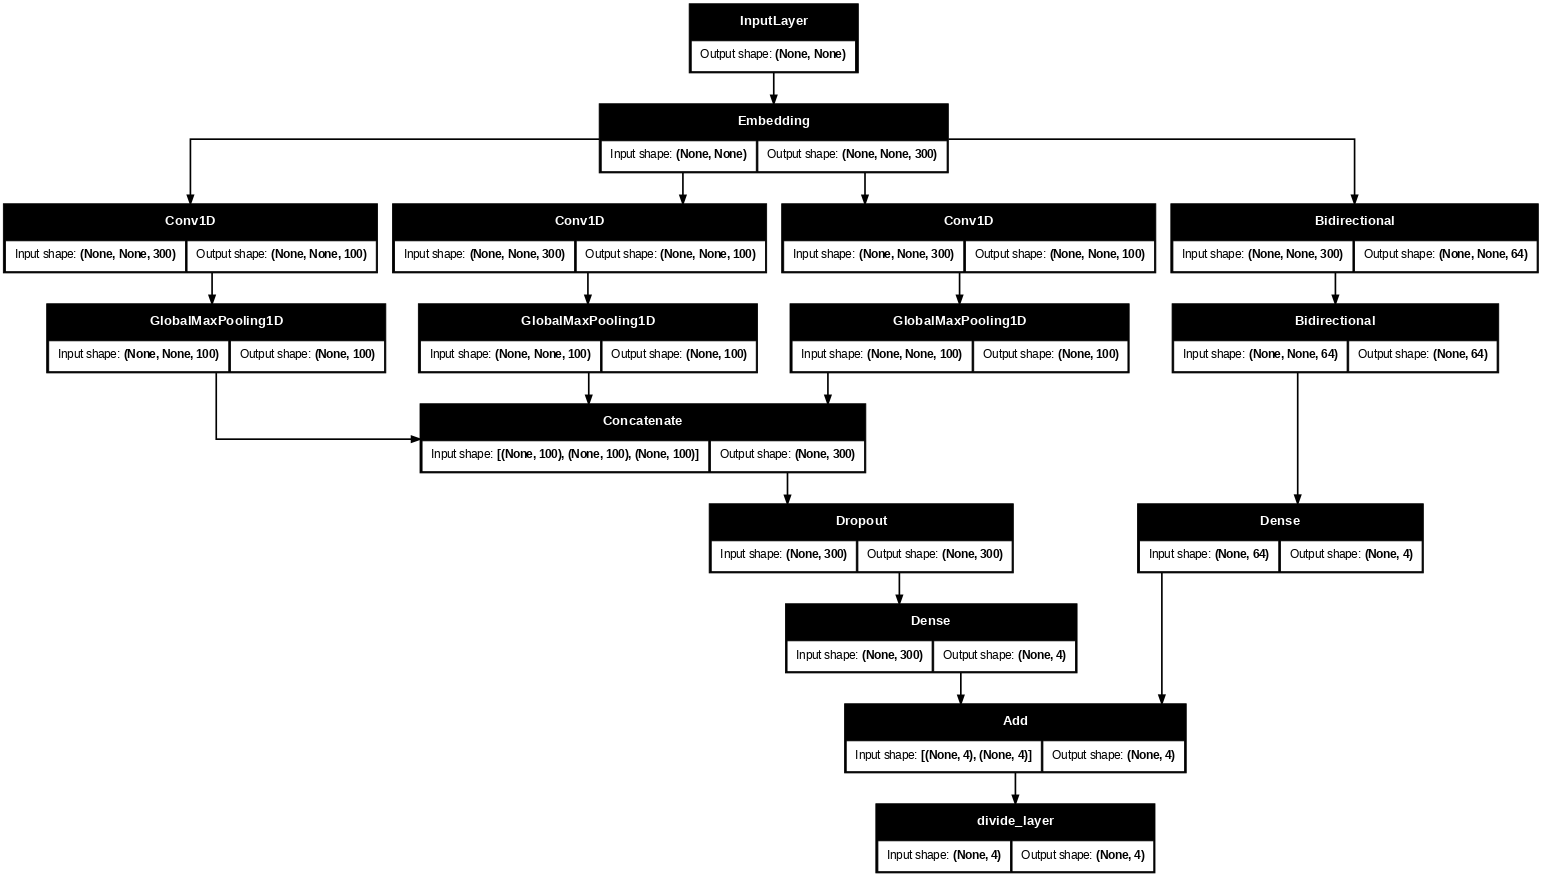

In [ ]:
plotting_model = create_model(lr=0., drop_rate=0.)
tf.keras.utils.plot_model(plotting_model, show_shapes=True, dpi=60)

In [ ]:
plotting_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 300)      │      9,000,600 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_3 (Conv1D)         │ (None, None, 100)      │         60,100 │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, None, 100)      │         90,100 │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, None, 100)      │        120,100 │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_3    │ (None, 100)            │              0 │ conv1d_3[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_4    │ (None, 100)            │              0 │ conv1d_4[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_5    │ (None, 100)            │              0 │ conv1d_5[0][0]         │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 300)            │              0 │ global_max_pooling1d_… │
│ (Concatenate)             │                        │                │ global_max_pooling1d_… │
│                           │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_2           │ (None, None, 64)       │         85,248 │ embedding[1][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 300)            │              0 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_3           │ (None, 64)             │         24,832 │ bidirectional_2[0][0]  │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 4)              │          1,204 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 4)              │            260 │ bidirectional_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 4)              │              0 │ dense_2[0][0],         │
│                           │                        │                │ dense_3[0][0]          │
├──────────────────────

 Total params: 9,382,444 (35.79 MB)

 Trainable params: 381,844 (1.46 MB)

 Non-trainable params: 9,000,600 (34.33 MB)

## Training & Evaluation

In [ ]:
reps = 5
lr = 9e-4
epochs = 12
drop_rate = 0.3

histories = []
val_accuracy, val_f1score, val_mf1score = [], [], []
test_accuracy, test_f1score, test_mf1score = [], [], []
for _ in range(reps):
  model = create_model(lr, drop_rate)

  history = model.fit(x=train_dataset, validation_data=val_dataset, epochs=epochs)
  histories.append(history)

  _, accuracy, f1score, mf1score = evaluate(model, val_dataset, val_labels)
  val_accuracy.append(accuracy)
  val_f1score.append(f1score)
  val_mf1score.append(mf1score)

  _, accuracy, f1score, mf1score = evaluate(model, test_dataset, test_labels)
  test_accuracy.append(accuracy)
  test_f1score.append(f1score)
  test_mf1score.append(mf1score)

Epoch 1/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.4216 - loss: 2.8674 - val_accuracy: 0.5694 - val_loss: 1.3221
Epoch 2/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.6264 - loss: 1.3357 - val_accuracy: 0.6714 - val_loss: 0.9956
Epoch 3/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.6918 - loss: 0.9913 - val_accuracy: 0.6907 - val_loss: 0.9507
Epoch 4/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.7700 - loss: 0.7108 - val_accuracy: 0.7100 - val_loss: 0.9597
Epoch 5/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.8190 - loss: 0.5546 - val_accuracy: 0.7487 - val_loss: 0.9551
Epoch 6/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.8443 - loss: 0.4481 - val_accuracy: 0.7311 - val_loss: 1.0491
Epoch 7/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.8900 - loss: 0.3200 - val_accuracy: 0.7346 - val_loss: 1.1525
Epoch 8/12
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.8967 - loss: 0.3330 - val_accuracy: 0.7434 -

**Overfitting Analysis**  
The gap between training and validation performance indicates that the model is overfitting the training data. Several factors contribute to this issue:
1. **Insufficient Data**: The relatively small training dataset of 2848 instances is insufficient for the model to learn the intricate nuances of the task, particularly given its inherent complexity.
2. **Task Complexity:** The 'disagree' and 'discuss' classes pose significant challenges due to their subtle distinctions. While 'unrelated' and 'agree' classes can often be identified through simple textual similarity, 'disagree' and 'discuss' require deeper semantic understanding and the ability to detect complex linguistic cues:
   - **Discuss class:** Discussing involves giving more details and different viewpoints.
   - **Disagree class:** Disagreement could involve simple negation terms or more complex negations like changing dates, quantities, or introducing opposing concepts (e.g. Sky is Blue vs. Sky is Black).

3. **Annotation Errors:** Manual inspection has revealed a non-negligible number of misannotations, further complicating the learning process.
4. **Language Challenges:** Arabic, the language of the dataset, presents additional complexities due to its rich morphology and diverse dialects.
5. **Class Imbalance:** The 'unrelated' class significantly outnumbers the other classes. Additionally, the 'disagree' and 'discuss' classes are underrepresented compared to the 'agree' and 'unrelated' classes. The relative lower representations of the 'discuss' and 'disagree' classes across the three sets exacerbates the classification challenge.

![image not found](tab_arastance.png)

**Mitigating Overfitting**  
While regularization techniques and early stopping may have limited effectiveness, addressing the underlying data limitations is crucial:
1. **Data Augmentation:** Explore techniques like back-translation, synonym replacement, and text generation to artificially expand the dataset.
2. **Transfer Learning:** Leverage pre-trained language models to incorporate prior knowledge and improve generalization.
3. **Ensemble Methods:** Combine multiple models to reduce variance and improve overall performance.



### Results

In [ ]:
print("Validation Resutls:")
print("=====================")
print(f"Mean Accuracy: {np.mean(val_accuracy):.3f}")
agree, disagree, discuss, unrelated = np.mean(val_f1score, axis=0)
print("Mean Per Class F1 scores:")
print(f"Agree   : {agree:.3f}")
print(f"Disagree: {disagree:.3f}")
print(f"Discuss : {discuss:.3f}")
print(f"Unrelated: {unrelated:.3f}")
print(f"Mean Macro F1 scores: {np.mean(val_mf1score):.3f}")

Validation Resutls:
Mean Accuracy: 0.744
Mean Per Class F1 scores:
Agree   : 0.686
Disagree: 0.687
Discuss : 0.476
Unrelated: 0.818
Mean Macro F1 scores: 0.667


In [ ]:
print("Testing Resutls:")
print("=====================")
print(f"Mean Accuracy: {np.mean(test_accuracy):.3f}")
agree, disagree, discuss, unrelated = np.mean(test_f1score, axis=0)
print("Mean Per Class F1 scores:")
print(f"Agree   : {agree:.3f}")
print(f"Disagree: {disagree:.3f}")
print(f"Discuss : {discuss:.3f}")
print(f"Unrelated: {unrelated:.3f}")
print(f"Mean Macro F1 scores: {np.mean(test_mf1score):.3f}")

Testing Resutls:
Mean Accuracy: 0.813
Mean Per Class F1 scores:
Agree   : 0.802
Disagree: 0.725
Discuss : 0.407
Unrelated: 0.883
Mean Macro F1 scores: 0.704
